In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LogisticRegression
import warnings

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv1D, Conv2D, Flatten, MaxPool1D, MaxPool2D

In [3]:
warnings.filterwarnings('ignore')

In [4]:
(X_train, y_train), (X_test, y_test) = \
tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [5]:
labels = [
  'T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'
]

In [6]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


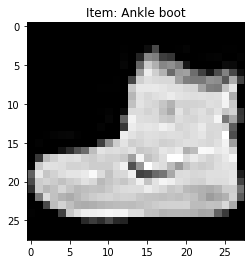

In [7]:
plt.figure()
plt.title(label=f'Item: {labels[y_train[0]]}')
plt.imshow(X=X_train[0], cmap='gray')

In [8]:
def pad(arr: np.ndarray, h_pad: int = 0, v_pad: int = 0):
    rows = len(arr)

    horizontal_pad = np.zeros(shape=(rows, arr.shape[1], h_pad))
    vertical_pad = np.zeros(shape=(rows, v_pad, arr.shape[2] + h_pad * 2))

    arr_copy = np.concatenate((horizontal_pad, arr, horizontal_pad), axis=2)
    arr_copy = np.concatenate((vertical_pad, arr_copy, vertical_pad), axis=1)

    return arr_copy

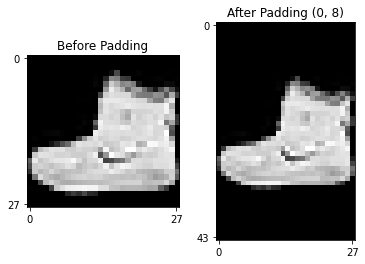

In [82]:
def compare_padded_image(X_train, h_pad=2, v_pad=2, sample=0):
    fig, ax = plt.subplots(1, 2)
    image = X_train[sample]

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Before Padding')
    ax[0].set_xticks(ticks=[0, image.shape[0] - 1])
    ax[0].set_yticks(ticks=[0, image.shape[1] - 1])

    ax[1].imshow(pad(X_train, h_pad=h_pad, v_pad=v_pad)[sample], cmap='gray')
    ax[1].set_title(f'After Padding ({h_pad}, {v_pad})')
    ax[1].set_xticks(ticks=[0, image.shape[0] + h_pad * 2 - 1])
    ax[1].set_yticks(ticks=[0, image.shape[1] + v_pad * 2 - 1])

    plt.axis('scaled')

compare_padded_image(X_train, 0, 8)

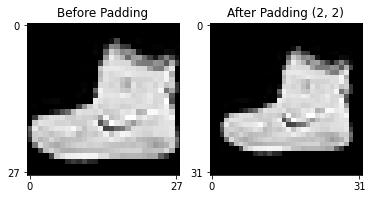

In [83]:
compare_padded_image(X_train, sample=0, h_pad=2, v_pad=2)

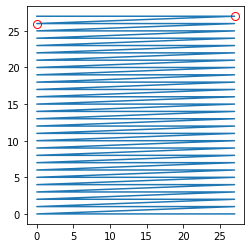

In [15]:
def plot_simple_flatten(side_length):
    d = [(side_length - r - 1, c) for c in range(side_length) for r in range(side_length)]
    x = np.array(d).T
    plt.plot(x[0], x[1])
    plt.xlim(-0.1, side_length ** 2 + 0.1)
    plt.ylim(-0.1, side_length ** 2 + 0.1)
    plt.axis('scaled')
    plt.plot(0, 26, 'o-r', ms=8, mfc='none')
    plt.plot(27, 27, 'o-r', ms=8, mfc='none')
    plt.show()

plot_simple_flatten(28)

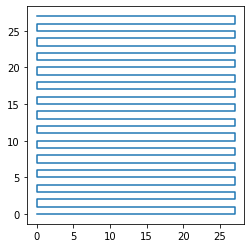

In [18]:
def plot_snake_flatten(side_length):
    ls = []
    for r in range(side_length):
        for c in range(0, side_length):
            if r % 2 == 0:
                ls.append((r, c))
            else:
                ls.append((r, side_length - c - 1))
    x = np.array(ls).T
    plt.plot(x[1], x[0])
    plt.xlim(-0.1, side_length ** 2 + 0.1)
    plt.ylim(-0.1, side_length ** 2 + 0.1)
    plt.axis('scaled')
    plt.show()

plot_snake_flatten(28)

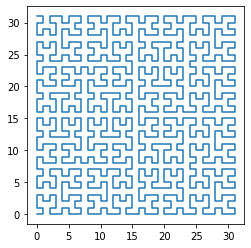

In [22]:
from hilbertcurve.hilbertcurve import HilbertCurve
from math import log2
def plot_hilbert_curve(side_length):
    d = np.array(HilbertCurve(log2(side_length), 2).points_from_distances(range(side_length ** 2))).T
    plt.plot(d[1], d[0])
    plt.xlim(-0.1, side_length ** 2 + 0.1)
    plt.ylim(-0.1, side_length ** 2 + 0.1)
    plt.axis('scaled')
    plt.show()

plot_hilbert_curve(32)

In [26]:
def sort_columns_snake(arr):
    arr_copy = arr.copy()
    arr_shape = arr.shape

    assert len(arr_shape) == 3, f"Samples must be 2-Dimensional"

    return np.concatenate([arr_copy[:, i] if i % 2 == 0 else arr_copy[:, i, ::-1] for i in range(arr_shape[1])], axis=1)


In [28]:
def revert_columns_snake(arr):
    arr_copy = arr.copy()
    arr_shape = arr.shape

    assert len(arr_shape) == 2, f"Samples must be 1-Dimensional"
    assert arr_shape[1] ** 0.5 == int(arr_shape[1] **
                                      0.5), f"Sample length must be a square number"

    chunk_size = int(arr_shape[1] ** 0.5)

    return np.concatenate([arr_copy[:, i * chunk_size: (i + 1) * chunk_size] if i % 2 == 0 else arr_copy[:, (i + 1) * chunk_size - 1: i * chunk_size - 1:-1] for i in range(chunk_size)], axis=1).reshape(-1, chunk_size, chunk_size)


In [23]:
def sort_columns_hilbert(arr):
    arr_copy = arr.copy()
    arr_shape = arr.shape

    assert arr_shape[1] == arr_shape[2], f"Samples must have square dimensions: {arr_shape[1]} != {arr_shape[2]}"

    from math import log2
    from hilbertcurve.hilbertcurve import HilbertCurve

    hcurve = HilbertCurve(log2(arr_shape[1]), 2)
    h_arr = np.array(hcurve.points_from_distances(range(arr_shape[1] ** 2)))
    mask = h_arr[:, 0] * arr_shape[1] + h_arr[:, 1]
    arr_resorted = arr_copy.reshape(-1, arr_shape[1] ** 2)[:, mask]
    
    return arr_resorted

In [24]:
def revert_columns_hilbert(arr):
    arr_copy = arr.copy()
    arr_shape = arr.shape

    assert len(arr_shape) == 2, f"Samples must be 1-Dimensional"
    assert arr_shape[1] ** 0.5 == int(arr_shape[1] ** 0.5), f"Sample length must be a square number"

    from math import log2
    from hilbertcurve.hilbertcurve import HilbertCurve

    side_length = int(arr_shape[1] ** 0.5)
    hcurve = HilbertCurve(int(side_length), 2)
    h_arr = np.array(hcurve.points_from_distances(range(arr_shape[1])))
    mask_transform = h_arr[:, 0] * side_length + h_arr[:, 1]
    mask = np.empty(shape=(arr_shape[1],), dtype=int)
    mask[mask_transform] = np.arange(arr_shape[1])
    arr_resorted = arr_copy[:, mask].reshape(-1, side_length, side_length)
    if int(log2(side_length)) % 2 == 1:
        return arr_resorted.transpose((0, 2, 1))
    return arr_resorted

In [ ]:
# np.random.seed(2)
# for i in range(1, 10):
#     A = np.random.randint(0, 10, size=(3, 2 ** i, 2 ** i))
#     print(2 ** i, np.abs(A - revert_columns_hilbert(sort_columns_hilbert(A))).sum())

In [25]:
# plt.imshow(revert_columns_hilbert(sort_columns_hilbert(pad(X_train, 2, 2)))[0].reshape(32, 32), cmap='gray')

In [29]:
def compress(arr, chunk_size=4, agg=np.mean):
    assert len(arr.shape) == 2, "Samples must be 1-Dimensional"
    if chunk_size > 1:
        arr_copy = np.empty(shape=(arr.shape[0], 0))
        for arr_ in np.array_split(ary=arr, indices_or_sections=arr.shape[1] // chunk_size, axis=1):
            arr_copy = np.concatenate((arr_copy, agg(arr_, axis=1).reshape((-1, 1))), axis=1)
        return arr_copy
    else:
        return arr

In [30]:
def save_obj_to_binary(obj, filepath):
    import pickle
    try:
        with open(file=filepath, mode='wb') as f:
            pickle.dump(obj=obj, file=f)
        return 0
    except:
        return 1

In [31]:
def evaluate_model(X_train, y_train, X_test, y_test, model, *args, **kwargs):
    from sklearn.metrics import accuracy_score
    from tensorflow.keras.models import Sequential

    model.fit(X_train, y_train, *args, **kwargs)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    if isinstance(model, Sequential):
        train_pred = train_pred.argmax(axis=1)
        test_pred = test_pred.argmax(axis=1)
        y_train = y_train.argmax(axis=1)
        y_test = y_test.argmax(axis=1)

    acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_test, test_pred)

    return acc, val_acc

In [32]:
def compare_model_scores(cnn_score, logreg_score, kind: str):
    print(f'Comparison of CNN against Logistic Regression ({kind})')
    df = pd.DataFrame(data={
        'CNN': cnn_score,
        'Logistic Regression': logreg_score
    }, index=['Training Accuracy', 'Testing Accuracy'])
    print(df)

In [43]:
def baseline_models(X_train, y_train, X_test, y_test):
    X_train2 = X_train.reshape((60000, 28 * 28))
    X_test2 = X_test.reshape((10000, 28 * 28))

    cnn = Sequential(layers=[
        Dense(10, input_shape=(28 * 28,), activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])

    cnn_score = evaluate_model(X_train2, to_categorical(
        y_train), X_test2, to_categorical(y_test), cnn, verbose=0)
    logreg_score = evaluate_model(
        X_train2, y_train, X_test2, y_test, LogisticRegression())

    compare_model_scores(cnn_score, logreg_score, 'baseline models')


baseline_models(X_train, y_train, X_test, y_test)


Comparison of CNN against Logistic Regression (baseline models)
                        CNN  Logistic Regression
Training Accuracy  0.798317               0.8632
Testing Accuracy   0.781600               0.8412


In [44]:
def data_normalisation(X_train, y_train, X_test, y_test):
    X_train2 = X_train.reshape((60000, 28 * 28)) / 255.0
    X_test2 = X_test.reshape((10000, 28 * 28)) / 255.0

    cnn = Sequential(layers=[
        Dense(10, input_shape=(28 * 28,), activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])

    cnn_score = evaluate_model(X_train2, to_categorical(
        y_train), X_test2, to_categorical(y_test), cnn, verbose=0)
    logreg_score = evaluate_model(
        X_train2, y_train, X_test2, y_test, LogisticRegression())

    compare_model_scores(cnn_score, logreg_score, 'data normalisation')

data_normalisation(X_train, y_train, X_test, y_test)

Comparison of CNN against Logistic Regression (data normalisation)
                        CNN  Logistic Regression
Training Accuracy  0.829717              0.86625
Testing Accuracy   0.813200              0.84390


In [37]:
def feature_engineering_simple_agg(X_train, y_train, X_test, y_test, kind='mean'):
    X_train2 = X_train.reshape((60000, 28 * 28, 1)) / 255.0
    X_test2 = X_test.reshape((10000, 28 * 28, 1)) / 255.0

    agg = np.mean if kind == 'mean' else np.max

    X_train3 = compress(X_train2.reshape(60000, -1), chunk_size=4, agg=agg)
    X_test3 = compress(X_test2.reshape(10000, -1), chunk_size=4, agg=agg)

    cnn = Sequential(layers=[
        InputLayer(input_shape=(28 * 28, 1)),
        MaxPool1D(pool_size=(4,), strides=4),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])

    cnn_score = evaluate_model(X_train2, to_categorical(
        y_train), X_test2, to_categorical(y_test), cnn, verbose=0)
    logreg_score = evaluate_model(
        X_train3, y_train, X_test3, y_test, LogisticRegression())

    compare_model_scores(cnn_score, logreg_score, f'simple {kind} aggregation')

feature_engineering_simple_agg(X_train, y_train, X_test, y_test, kind='max')

Comparison of CNN against Logistic Regression (simple max aggregation)
                      CNN  Logistic Regression
Training Accuracy  0.7756             0.823583
Testing Accuracy   0.7609             0.812700


In [38]:
feature_engineering_simple_agg(X_train, y_train, X_test, y_test, kind='mean')

Comparison of CNN against Logistic Regression (simple mean aggregation)
                        CNN  Logistic Regression
Training Accuracy  0.770783             0.833717
Testing Accuracy   0.763000             0.818900


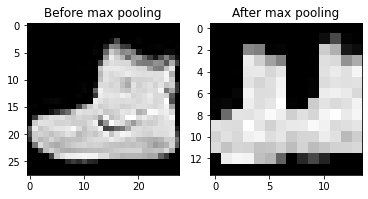

In [53]:
def compare_resolution_after_simple_pooling(X_train, sample=0, kind='max'):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(X_train[sample], cmap='gray')
    ax[0].set_title(f'Before {kind} pooling')
    agg = np.max if kind == 'max' else np.mean
    ax[1].imshow(compress(X_train.reshape(60000, -1), chunk_size=4, agg=agg)[sample].reshape(14, 14), cmap='gray')
    ax[1].set_title(f'After {kind} pooling')
    plt.show()

compare_resolution_after_simple_pooling(X_train, sample=0)

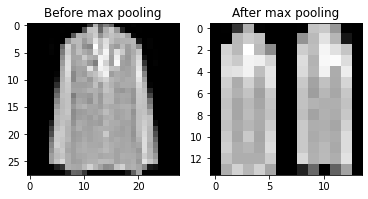

In [54]:
compare_resolution_after_simple_pooling(X_train, sample=4321)

In [40]:
def feature_engineering_snake_agg(X_train, y_train, X_test, y_test, kind='mean'):
    X_train2 = X_train / 255.0
    X_test2 = X_test / 255.0

    agg = np.mean if kind == 'mean' else np.max

    X_train3 = revert_columns_snake(compress(sort_columns_snake(X_train2), chunk_size=4, agg=agg))
    X_test3 = revert_columns_snake(compress(sort_columns_snake(X_test2), chunk_size=4, agg=agg))

    cnn = Sequential(layers=[
        InputLayer(input_shape=(14 * 14)),
        Dense(10, activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])

    cnn_score = evaluate_model(X_train3.reshape(60000, -1), to_categorical(
        y_train), X_test3.reshape(10000, -1), to_categorical(y_test), cnn, verbose=0)
    logreg_score = evaluate_model(
        X_train3.reshape(60000, -1), y_train, X_test3.reshape(10000, -1), y_test, LogisticRegression())

    compare_model_scores(cnn_score, logreg_score, f'snake {kind} aggregation')

feature_engineering_snake_agg(X_train, y_train, X_test, y_test, kind='max')

Comparison of CNN against Logistic Regression (snake max aggregation)
                        CNN  Logistic Regression
Training Accuracy  0.776883             0.823583
Testing Accuracy   0.766200             0.812700


In [41]:
feature_engineering_snake_agg(X_train, y_train, X_test, y_test, kind='mean')

Comparison of CNN against Logistic Regression (snake mean aggregation)
                        CNN  Logistic Regression
Training Accuracy  0.783817             0.833717
Testing Accuracy   0.777700             0.818900


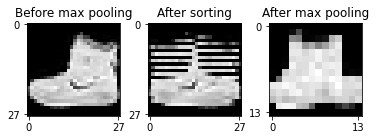

In [58]:
def compare_resolution_after_pooling_with_snake(X_train, sample=0, kind='max'):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(X_train[sample], cmap='gray')
    ax[0].set_title(f'Before {kind} pooling')
    ax[0].set_xticks(ticks=(0, 27))
    ax[0].set_yticks(ticks=(0, 27))

    ax[1].imshow(sort_columns_snake(X_train)[sample].reshape(28, 28), cmap='gray')
    ax[1].set_title(f'After sorting')
    ax[1].set_xticks(ticks=(0, 27))
    ax[1].set_yticks(ticks=(0, 27))

    agg = np.max if kind == 'max' else np.mean
    ax[2].imshow(
        revert_columns_snake(compress(sort_columns_snake(X_train), chunk_size=4, agg=agg))[sample].reshape(14, 14), cmap='gray')
    ax[2].set_title(f'After {kind} pooling')
    ax[2].set_xticks(ticks=(0, 13))
    ax[2].set_yticks(ticks=(0, 13))

    plt.subplots_adjust(wspace=0.3)
    plt.show()

compare_resolution_after_pooling_with_snake(X_train, sample=0, kind='max')

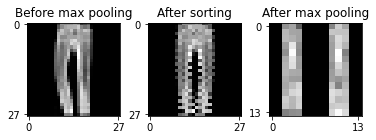

In [61]:
compare_resolution_after_pooling_with_snake(X_train, sample=1500, kind='max')

In [84]:
def feature_engineering_hilb_agg(X_train, y_train, X_test, y_test, kind='mean'):
    X_train2 = X_train / 255.0
    X_test2 = X_test / 255.0

    agg = np.max if kind == 'max' else np.mean

    X_train3 = revert_columns_hilbert(compress(sort_columns_hilbert(pad(X_train2, 2, 2)), chunk_size=4, agg=agg))
    X_test3 = revert_columns_hilbert(compress(sort_columns_hilbert(pad(X_test2, 2, 2)), chunk_size=4, agg=agg))

    cnn = Sequential(layers=[
        InputLayer(input_shape=(16 * 16)),
        Dense(10, activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])

    cnn_score = evaluate_model(X_train3.reshape(60000, -1), to_categorical(
        y_train), X_test3.reshape(10000, -1), to_categorical(y_test), cnn, verbose=0)
    logreg_score = evaluate_model(
        X_train3.reshape(60000, -1), y_train, X_test3.reshape(10000, -1), y_test, LogisticRegression())

    compare_model_scores(cnn_score, logreg_score, f'hilbert curve {kind} aggregation')

feature_engineering_hilb_agg(X_train, y_train, X_test, y_test, kind='max')

Comparison of CNN against Logistic Regression (hilbert curve max aggregation)
                      CNN  Logistic Regression
Training Accuracy  0.7876               0.8350
Testing Accuracy   0.7783               0.8208


In [85]:
feature_engineering_hilb_agg(X_train, y_train, X_test, y_test, kind='mean')

Comparison of CNN against Logistic Regression (hilbert curve mean aggregation)
                        CNN  Logistic Regression
Training Accuracy  0.793617             0.848183
Testing Accuracy   0.780600             0.832600


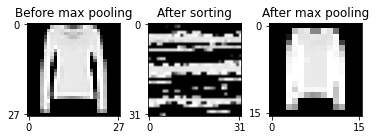

In [86]:
def compare_resolution_after_pooling_with_hilbert(X_train, sample=0, kind='max'):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(X_train[sample], cmap='gray')
    ax[0].set_title(f'Before {kind} pooling')
    ax[0].set_xticks(ticks=(0, 27))
    ax[0].set_yticks(ticks=(0, 27))

    ax[1].imshow(sort_columns_hilbert(pad(X_train, 2, 2))[sample].reshape(32, 32), cmap='gray')
    ax[1].set_title(f'After sorting')
    ax[1].set_xticks(ticks=(0, 31))
    ax[1].set_yticks(ticks=(0, 31))

    agg = np.max if kind == 'max' else np.mean
    ax[2].imshow(
        revert_columns_hilbert(compress(sort_columns_hilbert(pad(X_train, 2, 2)), chunk_size=4, agg=agg))[sample].reshape(16, 16), cmap='gray')
    ax[2].set_title(f'After {kind} pooling')
    ax[2].set_xticks(ticks=(0, 15))
    ax[2].set_yticks(ticks=(0, 15))

    plt.subplots_adjust(wspace=0.3)
    plt.show()

compare_resolution_after_pooling_with_hilbert(X_train, sample=1650, kind='max')

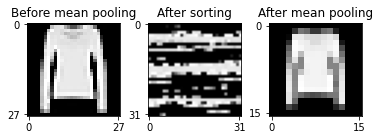

In [87]:
compare_resolution_after_pooling_with_hilbert(X_train, sample=1650, kind='mean')